# QRBS and Invasive Ductal Carcinoma

We are going to implement a **RBS** for a **Invasive Ductal Carcinoma** (**IDC**) using the **QRBS**. The rules for this kind of system can be shown in the following diagram:

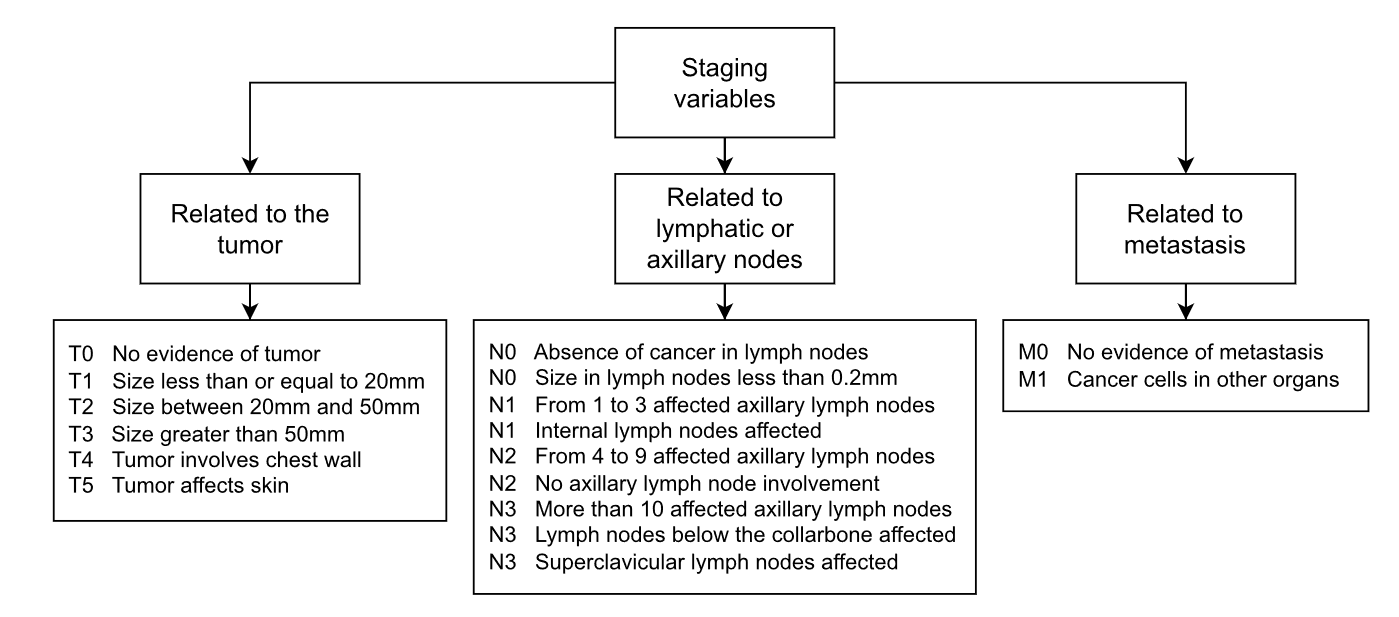


Given these inputs the following **IDC** stages can be identified:

| IDC-Stage | Compatible TNM classification                        |
|-----------|------------------------------------------------------|
| I-A       | T1 N0 M0                                             |
| I-B       | T0 N1 M0 / T1 N1 M0                                  |
| II-A      | T0 N1 M0 / T1 N1 M0 / T2 N0 M0                       |
| II-B      | T2 N1 M0 / T3 N0 M0                                  |
| III-A     | T0 N2 M0 / T1 N2 M0 / T2 N0 M0 / T3 N2 M0 / T3 N1 M0 |
| III-B     | T4 N0 M0 / T4 N1 M0 / T4 N2 M0                       |
| III-C     | TX N3 M0                                             |
| IV        | TX NY M1                                             |



**BE AWARE**

For this version of the **IDC** the number of qubits used by the **QRBS** is high (up to 28 qubits circuits can be generated) so for executing the simulation **HPC** resources are mandatory. In fact, for simulating the circuits, the Eviden **Quantum Learning Machine (QLM)** and the **LinAlg** solver should be used. 

If the user does not have access to a **QLM** this notebook can not be executed!! 

In [ ]:
import sys
sys.path.append("../")
import itertools as it
import pandas as pd

In [ ]:
from neasqc_qrbs.qrbs import QRBS
from neasqc_qrbs.knowledge_rep import AndOperator, OrOperator, NotOperator

In [ ]:
# myQLM qpus
from qpu.select_qpu import select_qpu
# List with the strings that should be provided for an ideal QPU
ideal_qpus = ["c", "python", "linalg", "mps", "qlmass_linalg", "qlmass_mps"]
qpu_config_c = {
    "qpu_type": ideal_qpus[2], 
}
qpu = select_qpu(qpu_config_c)

In [ ]:
from selectable_qpu import SelectableQPU
qpu_selected = SelectableQPU()

## 1. IDC using QRBS


In [ ]:
def idc_qrbs(row, qpu, type_qpu=None, shots=None, model='cf'):    
    idc =  QRBS()
    # Setting the input facts
    
    # Related to tumor
    t0 = idc.assert_fact('T0', 'No evidence of tumor')
    t1 = idc.assert_fact('T1', 'Size less than or equal to 20mm')
    t2 = idc.assert_fact('T2', 'Size between 20mm and 50mm')
    t3 = idc.assert_fact('T3', 'Size greater than 50mm')
    t4 = idc.assert_fact('T4', 'Tumor involves chest wall')
    t5 = idc.assert_fact('T5', 'Tumor affects skin')
    
    # Related to lymphatic or auxilary nodes
    n0a = idc.assert_fact('N0A', 'Absence of cancer in lymph nodes')
    n0b = idc.assert_fact('N0B', 'Size in lymph nodes less than 0.2mm')
    n0 = OrOperator(n0a, n0b)
    
    n1a = idc.assert_fact('N1A', 'From 1 to 3 affected axillary lymph nodes')
    n1b = idc.assert_fact('N1B', 'Internal lymph nodes affected')
    n1 = OrOperator(n1a, n1b)
    
    n2a = idc.assert_fact('N2A', 'From 4 to 9 affected axillary lymph nodes')
    n2b = idc.assert_fact('N2B', 'No axillary lymph node involvement')
    n2 = OrOperator(n2a, n2b)
    
    n3a = idc.assert_fact('N3A', 'More than 10 affected axillary lymph nodes')
    n3b = idc.assert_fact('N3B', 'Lymph nodes below the collarbone affected')
    n3c = idc.assert_fact('N3C', 'Superclavicular lymph nodes affected')

    n3 = OrOperator(n3a, OrOperator(n3b, n3c))   
    
    # Related to metastasis
    m0 = idc.assert_fact('M0', 'No evidence of metastasis')
    m1 = idc.assert_fact('M1', 'Cancer cells in other organs')
    
    inputs = [t0, t1, t2, t3, t4, t5, n0a, n0b, n1a, n1b, n2a, n2b, n3a, n3b, n3c, m0, m1]
    
    # Fixed the precision of eac input fact
    for i in inputs:
        i.precision = row[i.attribute]

    # Combination of input facts for creating TNM staging system
    t1n0m0 = AndOperator(t1, AndOperator(n0, m0))    
    t0n1m0 = AndOperator(t0, AndOperator(n1, m0))
    t1n1m0 = AndOperator(t1, AndOperator(n1, m0))
    t2n0m0 = AndOperator(t2, AndOperator(n0, m0))
    t2n1m0 = AndOperator(t2, AndOperator(n1, m0))
    t3n0m0 = AndOperator(t3, AndOperator(n0, m0))
    t0n2m0 = AndOperator(t0, AndOperator(n2, m0))
    t1n2m0 = AndOperator(t1, AndOperator(n2, m0))
    t3n2m0 = AndOperator(t3, AndOperator(n2, m0))
    t3n1m0 = AndOperator(t3, AndOperator(n1, m0))
    t4n0m0 = AndOperator(t4, AndOperator(n0, m0))
    t4n1m0 = AndOperator(t4, AndOperator(n1, m0))
    t4n2m0 = AndOperator(t4, AndOperator(n2, m0))
    txn3m0 = AndOperator(n3, m0)
    txnym1 = m1
    
    # Output facts
    ia   = idc.assert_fact('IA', 'Stage I-A')
    ib   = idc.assert_fact('IB', 'Stage I-B')
    iia  = idc.assert_fact('IIA', 'Stage II-A')
    iib  = idc.assert_fact('IIB', 'Stage II-B')
    iiia = idc.assert_fact('IIIA', 'Stage III-A')
    iiib = idc.assert_fact('IIIB', 'Stage III-B')
    iiic = idc.assert_fact('IIIC', 'Stage III-C')
    iv   = idc.assert_fact('IV', 'Stage IV')
    
    outputs = [ia, ib, iia, iib, iiia, iiib, iiic, iv]
    
    # Rules of the IDC
    rule_ia    = idc.assert_rule(t1n0m0, ia, 1.0)
    rule_ib    = idc.assert_rule(OrOperator(t0n1m0, t1n1m0), ib, 1.0)
    rule_iia   = idc.assert_rule(OrOperator(t0n1m0, OrOperator(t1n1m0, t2n0m0)), iia, 1.0)
    rule_iib   = idc.assert_rule(OrOperator(t2n1m0, t3n0m0), iib, 1.0)
    rule_iiia  = idc.assert_rule(
        OrOperator(
            t0n2m0, 
            OrOperator(
                OrOperator(t1n2m0, t2n0m0), 
                OrOperator(t3n2m0, t3n1m0)
            )
        ),
        iiia, 
        1.0
    )
    rule_iiib  = idc.assert_rule(OrOperator(t4n0m0, OrOperator(t4n1m0, t4n2m0)), iiib, 1.0)
    rule_iiic  = idc.assert_rule(txn3m0, iiic, 1.0)
    rule_iv    = idc.assert_rule(txnym1, iv, 1.0) 
    
    # Defining the islands
    staging_ia    = idc.assert_island([rule_ia])
    staging_ib    = idc.assert_island([rule_ib])
    staging_iia   = idc.assert_island([rule_iia])
    staging_iib   = idc.assert_island([rule_iib])
    staging_iiia  = idc.assert_island([rule_iiia])
    staging_iiib  = idc.assert_island([rule_iiib])
    staging_iiic  = idc.assert_island([rule_iiic])
    staging_iv    = idc.assert_island([rule_iv])    
    
    qpu.execute(idc, qpu=type_qpu, shots=shots, model=model)
    
    
    data = [out.precision for out in outputs]
    columns = ["Stage I-A", "Stage I-B", "Stage II-A", "Stage II-B",
        "Stage III-A", "Stage III-B", "Stage III-C", "Stage IV"
    ]
    pdf = pd.DataFrame(data, index = columns).T
    return pdf

In [ ]:
#Posible t values
t = [[float(i==j) for i in range(6)] for j in range(5)]
#Posible n values
n = [[float(i==j) for i in range(9)] for j in range(9)]
m = [[int(i==j) for i in range(2)] for j in range(2)]
data = [list(it.chain.from_iterable(i)) for i in it.product(t, n, m)]
columns = ['T0','T1','T2','T3','T4','T5','N0A','N0B','N1A','N1B','N2A','N2B','N3A','N3B','N3C','M0','M1']
idc_df = pd.DataFrame(data, columns=columns)

In [ ]:
idc_df

In [ ]:
#Stage I-A
stage_1_a = (idc_df["T1"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)

step = idc_df[stage_1_a]
print(step)

pdf_stage_1_a = pd.concat([idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_1_a

In [ ]:
# Stage I-B (II-A)
stage_1_b = (
    ((idc_df["T0"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T1"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0))
)
step = idc_df[stage_1_b] 
print(step)

pdf_stage_1_b = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_1_b

In [ ]:
# Stage II-A (or I-B)

stage_2_a = (
    ((idc_df["T0"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T1"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T2"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) 
)

step = idc_df[stage_2_a]
print(step)
pdf_stage_2_a = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])


In [ ]:
pdf_stage_2_a

In [ ]:
# Stage II-B

stage_2_b = (
    ((idc_df["T2"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T3"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) 
)
step = idc_df[stage_2_b]
print(step)
pdf_stage_2_b = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_2_b

In [ ]:
# Stage III-A

stage_3_a = (
    ((idc_df["T0"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T1"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T2"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T3"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T3"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0))
)

step = idc_df[stage_3_a]
print(step)
pdf_stage_3_a = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_3_a

In [ ]:
# Stage III-B

stage_3_b = (
    ((idc_df["T4"] ==1) & ((idc_df["N0A"] ==1) |(idc_df["N0B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T4"] ==1) & ((idc_df["N1A"] ==1) |(idc_df["N1B"] ==1)) & (idc_df["M0"] ==1.0)) |
    ((idc_df["T4"] ==1) & ((idc_df["N2A"] ==1) |(idc_df["N2B"] ==1)) & (idc_df["M0"] ==1.0))
)
step = idc_df[stage_3_b]
print(step)
pdf_stage_3_b = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_3_b

In [ ]:
# Stage III-C
stage_3_c = (
    ((idc_df["N3A"] == 1) | (idc_df["N3B"] == 1) | (idc_df["N3C"] == 1)) &
    (idc_df["M0"] == 1)
)
step = idc_df[stage_3_c]
print(step)
pdf_stage_3_c = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_stage_3_c

In [ ]:
# Stage IV

stage_4 = (
    idc_df["M1"] == 1
)
step = idc_df[stage_4]
print(step)
pdf_stage_4 = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])


In [ ]:
pdf_stage_4

In [ ]:
no_stage = (
    ~(stage_1_a | stage_1_b | stage_2_a | stage_2_b | stage_3_a | stage_3_b | stage_3_c | stage_4)
)
step = idc_df[no_stage]
print(step)
pdf_no_stage = pd.concat(
    [idc_qrbs(row[1], qpu_selected, type_qpu = qpu, shots=100) for row in step.iterrows()])

In [ ]:
pdf_no_stage

## 3. QPU ruidosa

In [ ]:
import json
from qpu.benchmark_utils import combination_for_list

In [ ]:
with open("./qpu_noisy_stochastic.json") as json_file:
    noisy_cfg = json.load(json_file)
qpu_list = combination_for_list(noisy_cfg)

In [ ]:
noisy_id = -1
noisy_qpu_cfg = qpu_list[noisy_id]
print(noisy_qpu_cfg)

In [ ]:
noisy_qpu = select_qpu(noisy_qpu_cfg)

In [ ]:
test_pdf = idc_df[stage_3_a]

In [ ]:
test_pdf.iloc[0]

In [ ]:
idc_qrbs(test_pdf.iloc[0], qpu_selected, type_qpu = noisy_qpu, shots=100)